# Forecasting Problem for Monthly Beer Production

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
from pandas import datetime
from sklearn.preprocessing import MinMaxScaler

<ipython-input-1-63642495f814>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# Importing libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import SimpleRNN
from tensorflow.python.keras.layers import RNN
from tensorflow.python.keras.layers import GRU

In [59]:
# Setting the seed for the tensorflow

from tensorflow.python import set_random_seed
set_random_seed(2)

In [3]:
# Loading the data univariate time series

df = pd.read_csv('C:\\Users\\hites\\Downloads\\monthly-beer-production-in-austr.csv', header=0, index_col=0)

In [4]:
df.shape

(476, 1)

In [5]:
df = df.iloc[:468]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468 entries, 1956-01 to 1994-12
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Monthly beer production  468 non-null    float64
dtypes: float64(1)
memory usage: 7.3+ KB


# Data Preprocessing

**For time series data, we need to provide the inputs (X) and the corresponding outputs(y). To achieve for the univariate time series, we need to shift the data to be used as input with a lag at t-1 as input for t output time period. So, we are shifting our data in this case it is monthly so doing it for 12 lag periods to be used as inputs and outputs at t period.**

In [7]:
# Function to create the numpy array with the lag. For this case, monthly data is there so lag from 1 to 12 for each of the 
# 12 months is being used. We are shifting by 1 more time for month. For 2nd month, we would have 2 lags to get the 1st value 
# of the production of the beer and for 3rd month we would have lag of 3 months for our data to come at the very 1st value
# Shifting by 1 extra lag for each month

def series_to_supervised(data, n_in=1, n_out=12):
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

In [8]:
# Creating the lagged data to be feed to the model as input as we have a univariate time series

df_pre = series_to_supervised(df)

In [9]:
# Dataframe from the numpy array 

df_pre_df = pd.DataFrame(data=df_pre)

In [10]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

<ipython-input-10-da6ed16532e4>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [11]:
# Noe we have a dataframe which has original values in 1 column and lagged values in other 12 columns.

df_pre_df.shape

(456, 13)

In [12]:
# Splitting the entire data into train using the first 70% of the data sequentially for training the model

X_train = df_pre_df.iloc[0:324,1:]

In [13]:
# Training labels or actual beer production values

y_train = df_pre_df.iloc[0:324,0]

In [14]:
type(X_train)

pandas.core.frame.DataFrame

In [15]:
y_train = y_train.values.reshape(-1,1)

In [16]:
# Splitting the entire data into validation using the remaining 30% of the data sequentially for validation of the model

X_val = df_pre_df.iloc[324:,1:]

In [17]:
# Validation labels or actual beer production values

y_val = df_pre_df.iloc[324:,0]

In [18]:
y_val = y_val.values.reshape(-1,1)

# Scaling the Data 

**Scaling the data so that the whole time series is in the same range of values for the model to be unbiased.**

In [19]:
# MinMax Scaler to scale the train and the validation data between 0 to 1 

minmax = MinMaxScaler()

In [20]:
# Scaling the Training data

X_train = minmax.fit_transform(X_train)

In [21]:
X_train.shape

(324, 12)

In [22]:
# Scaling the Validation Data

X_val = minmax.fit_transform(X_val)

In [23]:
# Scaling the training forecast

y_train = minmax.fit_transform(y_train)

In [24]:
# Scaling the validation forecast

y_val = minmax.fit_transform(y_val)

# **Simple Back Propogation Feed Forward Neural Network for Time Series Forecasting of the Beer Production**

In [25]:
# Creating a model with 1 hidden node having 24 neurons with activation function relu and the output is a single layer

model = Sequential()
model.add(Dense(24, input_dim=X_train.shape[1], kernel_initializer='normal',use_bias=True, activation='relu'))
#model.add(Dense(30, activation='sigmoid',use_bias=True))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                312       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Defining the loss function for the Model

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [27]:
# Fitting the Simple Back Prop algorithm on train data along with evaluating the performance on the validation data

history = model.fit(X_train, y_train, epochs=300, batch_size=40,  verbose=1, shuffle=False, validation_data=(X_val, y_val))

Epoch 1/300
9/9 [==============================] - 0s 14ms/step - loss: 0.1000 - mse: 0.1000 - val_loss: 0.0795 - val_mse: 0.0795
Epoch 2/300
9/9 [==============================] - 0s 4ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 3/300
9/9 [==============================] - 0s 4ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0476 - val_mse: 0.0476
Epoch 4/300
9/9 [==============================] - 0s 4ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 5/300
9/9 [==============================] - 0s 4ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 6/300
9/9 [==============================] - 0s 4ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0426 - val_mse: 0.0426
Epoch 7/300
9/9 [==============================] - 0s 5ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0416 - val_mse: 0.0416
Epoch 8/300
9/9 [==============================] - 0s 5ms/step - loss: 0.0112 - mse: 0.0112 - va

In [28]:
# Training MSE of the Model

MSE_train = history.history['mse']

In [29]:
# Computational Effort calculation for the model multiplying epochs, number of weights and batch size

epoch_x_mul = []
for i in range (1,(len(history.epoch)+1)):
    epoch_x_mul.append(i * model.count_params() * 30)

In [30]:
# Validation MSE of the Model

MSE_val = history.history['val_mse']

In [31]:
# Number of Epochs over which the model is run

epoch_x = history.epoch

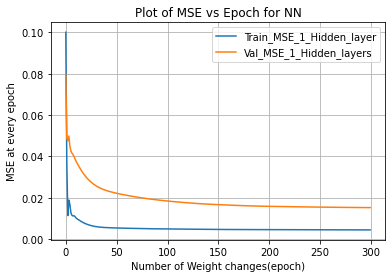

In [32]:
# Training and Validation MSE plotted against the number of the epochs for the model

from matplotlib import pyplot as plt
plt.plot(epoch_x,MSE_train, label = 'Train_MSE_1_Hidden_layer')
plt.plot(epoch_x,MSE_val, label = 'Val_MSE_1_Hidden_layers')
plt.grid()
plt.ylabel('MSE at every epoch')
plt.xlabel('Number of Weight changes(epoch)')
plt.title('Plot of MSE vs Epoch for NN')
plt.legend()

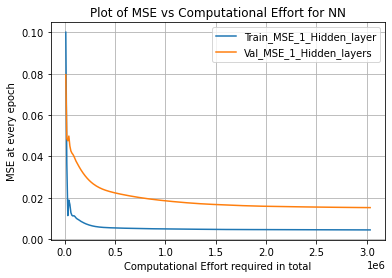

In [33]:
# Training and Validation MSE plotted against the Computational Effort it takes to reach this particular MSE over time. 
# Computational effort it took for that MSE to achieve for the Train and Validation data

from matplotlib import pyplot as plt
plt.plot(epoch_x_mul,MSE_train, label = 'Train_MSE_1_Hidden_layer')
plt.plot(epoch_x_mul,MSE_val, label = 'Val_MSE_1_Hidden_layers')
plt.grid()
plt.ylabel('MSE at every epoch')
plt.xlabel('Computational Effort required in total')
plt.title('Plot of MSE vs Computational Effort for NN')
plt.legend()

**Computational Effort required is very high as seen from the graph to the power of 6 to achieve the MSE of around 0.02. The simple back propogation doesn't have memory to have past memory or connections to itself but only a simple feed forward network where the connections go only from 1 layer to another and not backwards.** 

# **Backpropogation through Time(BPTT)**

In [34]:
# Reshaping the input as required by the Backpropogation through time(BPTT) 3 dimension [samples,timestep,features]
# We have 324 samples in our train data, 1 timestep as we have new sample at each step and 12 features

X_train_RNN = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [35]:
X_train_RNN.shape

(324, 1, 12)

In [36]:
# Reshaping the validation as required by the Backpropogation through time(BPTT) 3 dimension [samples,timestep,features]
# We have 132 samples in our validation data, 1 timestep as we have new sample at each step and 12 features

X_val_RNN = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [37]:
X_val_RNN.shape

(132, 1, 12)

**Backpropogation through time model created in Keras using the SimpleRNN layer instead of Dense Layer**

In [38]:
# Model with SimpleRNN layer with 1 RNN layer relu activation function having 1 output is created

model_RNN = Sequential()
model_RNN.add(SimpleRNN(units=1, input_shape=(1,12), activation='relu',use_bias=True, return_sequences = True))
#model.add(Dense(30, activation='sigmoid',use_bias=True))
model_RNN.add(Dense(1))
model_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 1)              14        
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1)              2         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Defining the loss function for the RNN model

model_RNN.compile(loss='mse', optimizer='adam', metrics=['mse'])

Shuffle=False is explicitly mentioned so that the data is not shuffled as we want our data to be feed sequentially for a time series forecasting model

In [40]:
# Fitting the train and validation data using the model with 300 epochs and batch_size of 30.

history_RNN = model_RNN.fit(X_train_RNN,y_train,epochs=300, batch_size=40,  verbose=1, shuffle=False, validation_data=(X_val_RNN, y_val))

Epoch 1/300
9/9 [==============================] - 0s 18ms/step - loss: 0.9540 - mse: 0.9540 - val_loss: 0.6888 - val_mse: 0.6888
Epoch 2/300
9/9 [==============================] - 0s 4ms/step - loss: 0.8165 - mse: 0.8165 - val_loss: 0.6018 - val_mse: 0.6018
Epoch 3/300
9/9 [==============================] - 0s 4ms/step - loss: 0.6955 - mse: 0.6955 - val_loss: 0.5264 - val_mse: 0.5264
Epoch 4/300
9/9 [==============================] - 0s 4ms/step - loss: 0.5908 - mse: 0.5908 - val_loss: 0.4622 - val_mse: 0.4622
Epoch 5/300
9/9 [==============================] - 0s 5ms/step - loss: 0.5012 - mse: 0.5012 - val_loss: 0.4092 - val_mse: 0.4092
Epoch 6/300
9/9 [==============================] - 0s 4ms/step - loss: 0.4264 - mse: 0.4264 - val_loss: 0.3652 - val_mse: 0.3652
Epoch 7/300
9/9 [==============================] - 0s 5ms/step - loss: 0.3662 - mse: 0.3662 - val_loss: 0.3291 - val_mse: 0.3291
Epoch 8/300
9/9 [==============================] - 0s 5ms/step - loss: 0.3179 - mse: 0.3179 - va

In [41]:
# Computational effort required by the RNN model obtained by multiplying the epochs, number of weights and batch size 

epoch_x_mul_RNN = []
for i in range (1,(len(history_RNN.epoch)+1)):
    epoch_x_mul_RNN.append(i * model_RNN.count_params() * 30)

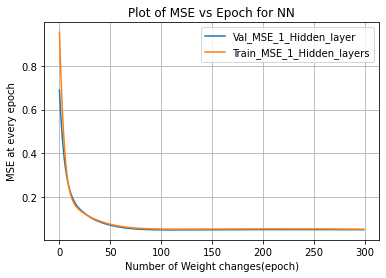

In [42]:
# Training and Validation Mse over the number of epochs for RNN

from matplotlib import pyplot as plt
plt.plot(history_RNN.epoch,history_RNN.history['val_mse'], label = 'Val_MSE_1_Hidden_layer')
plt.plot(history_RNN.epoch,history_RNN.history['mse'], label = 'Train_MSE_1_Hidden_layers')
plt.grid()
plt.ylabel('MSE at every epoch')
plt.xlabel('Number of Weight changes(epoch)')
plt.title('Plot of MSE vs Epoch for NN')
plt.legend()

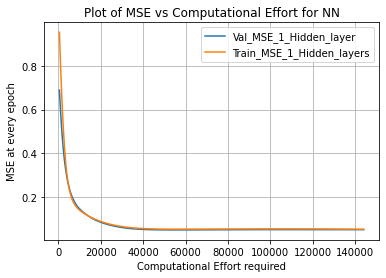

In [43]:
# Training and Validation MSE plotted against the Computational Effort it takes to reach this particular MSE over time. 
# Computational effort it took for that MSE to achieve for the Train and Validation data for RNN

from matplotlib import pyplot as plt
plt.plot(epoch_x_mul_RNN,history_RNN.history['val_mse'], label = 'Val_MSE_1_Hidden_layer')
plt.plot(epoch_x_mul_RNN,history_RNN.history['mse'], label = 'Train_MSE_1_Hidden_layers')
plt.grid()
plt.ylabel('MSE at every epoch')
plt.xlabel('Computational Effort required')
plt.title('Plot of MSE vs Computational Effort for NN')
plt.legend()

**BPTT allows remembering the past outputs and can have connections to itself to create the effect of past outputs infleuncing the current network outputs where the weights are constrained and these free weights are very less so the flexibility is less but the computational power required is less as seen from the graph. The order of computational effort is almost 1 order lower than Back Propogation without time. No overfitting is happening in the model.**   

# **LSTM**

In [44]:
# LSTM Layer added to create a LSTM model for predicting the beer prediction with 1 LSTM unit and relu activation function

model_LSTM = Sequential()
model_LSTM.add(LSTM(units=1, input_shape = (1,12), return_sequences = True,use_bias=True, activation='relu'))
#model.add(Dense(30, activation='sigmoid',use_bias=True))
model_LSTM.add(Dense(1))
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 1)              56        
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1)              2         
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Model loss function for LSTM

model_LSTM.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [46]:
# Fitting the Model with Training and Validation for performance evaluation with epochs = 30 and 40 batch size for the LSTM

history_LSTM = model_LSTM.fit(X_train_RNN,y_train,epochs=300, batch_size=40,  verbose=1,shuffle=False, validation_data=(X_val_RNN, y_val))

Epoch 1/300
9/9 [==============================] - 0s 20ms/step - loss: 0.2185 - mse: 0.2185 - val_loss: 0.1748 - val_mse: 0.1748
Epoch 2/300
9/9 [==============================] - 0s 5ms/step - loss: 0.2113 - mse: 0.2113 - val_loss: 0.1680 - val_mse: 0.1680
Epoch 3/300
9/9 [==============================] - 0s 4ms/step - loss: 0.2043 - mse: 0.2043 - val_loss: 0.1610 - val_mse: 0.1610
Epoch 4/300
9/9 [==============================] - 0s 4ms/step - loss: 0.1971 - mse: 0.1971 - val_loss: 0.1538 - val_mse: 0.1538
Epoch 5/300
9/9 [==============================] - 0s 4ms/step - loss: 0.1893 - mse: 0.1893 - val_loss: 0.1459 - val_mse: 0.1459
Epoch 6/300
9/9 [==============================] - 0s 5ms/step - loss: 0.1794 - mse: 0.1794 - val_loss: 0.1370 - val_mse: 0.1370
Epoch 7/300
9/9 [==============================] - 0s 6ms/step - loss: 0.1650 - mse: 0.1650 - val_loss: 0.1260 - val_mse: 0.1260
Epoch 8/300
9/9 [==============================] - 0s 5ms/step - loss: 0.1430 - mse: 0.1430 - va

In [47]:
# Computational Effort required by the LSTM model obtained by multiplying epochs, number of weights and batch size

epoch_x_mul_LSTM = []
for i in range (1,(len(history_LSTM.epoch)+1)):
    epoch_x_mul_LSTM.append(i * model_LSTM.count_params() * 30)

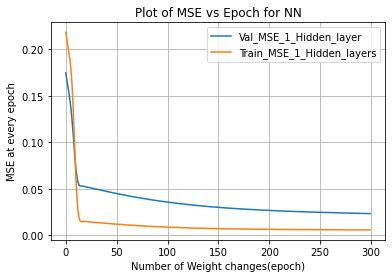

In [48]:
# Training and Validation MSE varying over the Epochs for the LSTM model

from matplotlib import pyplot as plt
plt.plot(history_LSTM.epoch,history_LSTM.history['val_mse'], label = 'Val_MSE_1_Hidden_layer')
plt.plot(history_LSTM.epoch,history_LSTM.history['mse'], label = 'Train_MSE_1_Hidden_layers')
plt.grid()
plt.ylabel('MSE at every epoch')
plt.xlabel('Number of Weight changes(epoch)')
plt.title('Plot of MSE vs Epoch for NN')
plt.legend()

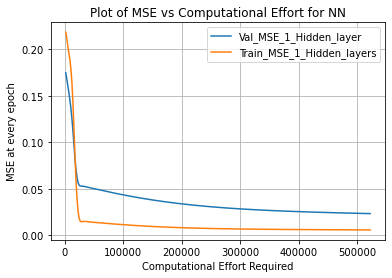

In [49]:
# Training and Validation MSE plotted against the Computational Effort it takes to reach this particular MSE over time. 
# Computational effort it took for that MSE to achieve for the Train and Validation data for LSTM

from matplotlib import pyplot as plt
plt.plot(epoch_x_mul_LSTM,history_LSTM.history['val_mse'], label = 'Val_MSE_1_Hidden_layer')
plt.plot(epoch_x_mul_LSTM,history_LSTM.history['mse'], label = 'Train_MSE_1_Hidden_layers')
plt.grid()
plt.ylabel('MSE at every epoch')
plt.xlabel('Computational Effort Required')
plt.title('Plot of MSE vs Computational Effort for NN')
plt.legend()

**LSTM are one of the special kinds of the RNN's where we have forgetting gates and input gates. Cell state and outputs are calculated to see how the learning happens balancing the elasticity and plasticity to keep old data points along with learning new data points. Computational power required is less than Simple Backpropogation. But for same or less computational effort it required, LSTM has better performance than RNN for the MSE.**

# **GRU**

In [50]:
# GRU Layer added to create a GRU model with 1 GRU unit and relu activation function

model_GRU = Sequential()
model_GRU.add(GRU(units=1, input_shape = (1,12), return_sequences = True, use_bias=True, activation='relu'))
#model.add(Dense(30, activation='sigmoid',use_bias=True))
model_GRU.add(Dense(1))
model_GRU.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 1)              45        
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1)              2         
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Defining the Model loss function for the GRU model

model_GRU.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [52]:
# Fitting the Model with Train and Validation data for 300 epochs running for model performance evaluation 

history_GRU = model_GRU.fit(X_train_RNN,y_train,epochs=300, batch_size=40,  verbose=1, shuffle=False, validation_data=(X_val_RNN, y_val))

Epoch 1/300
9/9 [==============================] - 0s 20ms/step - loss: 0.2150 - mse: 0.2150 - val_loss: 0.1744 - val_mse: 0.1744
Epoch 2/300
9/9 [==============================] - 0s 4ms/step - loss: 0.2056 - mse: 0.2056 - val_loss: 0.1668 - val_mse: 0.1668
Epoch 3/300
9/9 [==============================] - 0s 24ms/step - loss: 0.1954 - mse: 0.1954 - val_loss: 0.1588 - val_mse: 0.1588
Epoch 4/300
9/9 [==============================] - 0s 4ms/step - loss: 0.1842 - mse: 0.1842 - val_loss: 0.1503 - val_mse: 0.1503
Epoch 5/300
9/9 [==============================] - 0s 4ms/step - loss: 0.1719 - mse: 0.1719 - val_loss: 0.1415 - val_mse: 0.1415
Epoch 6/300
9/9 [==============================] - 0s 4ms/step - loss: 0.1586 - mse: 0.1586 - val_loss: 0.1324 - val_mse: 0.1324
Epoch 7/300
9/9 [==============================] - 0s 5ms/step - loss: 0.1448 - mse: 0.1448 - val_loss: 0.1232 - val_mse: 0.1232
Epoch 8/300
9/9 [==============================] - 0s 5ms/step - loss: 0.1305 - mse: 0.1305 - v

In [53]:
# Computational Effort required by the GRU model obtained by multiplying the epochs, number of weights and batch size

epoch_x_mul_GRU = []
for i in range (1,(len(history_GRU.epoch)+1)):
    epoch_x_mul_GRU.append(i * model_GRU.count_params() * 30)

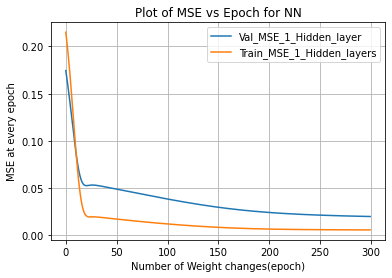

In [54]:
# Training and Validation MSE varying over the Epochs for the GRU model

from matplotlib import pyplot as plt
plt.plot(history_GRU.epoch,history_GRU.history['val_mse'], label = 'Val_MSE_1_Hidden_layer')
plt.plot(history_GRU.epoch,history_GRU.history['mse'], label = 'Train_MSE_1_Hidden_layers')
plt.grid()
plt.ylabel('MSE at every epoch')
plt.xlabel('Number of Weight changes(epoch)')
plt.title('Plot of MSE vs Epoch for NN')
plt.legend()

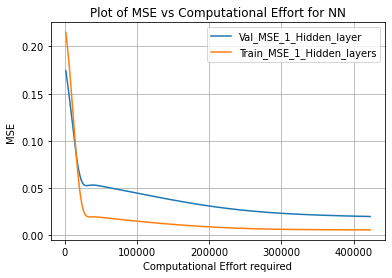

In [55]:
# Training and Validation MSE plotted against the Computational Effort it takes to reach this particular MSE over time. 
# Computational effort it took for that MSE to achieve for the Train and Validation data for GRU

from matplotlib import pyplot as plt
plt.plot(epoch_x_mul_GRU,history_GRU.history['val_mse'], label = 'Val_MSE_1_Hidden_layer')
plt.plot(epoch_x_mul_GRU,history_GRU.history['mse'], label = 'Train_MSE_1_Hidden_layers')
plt.grid()
plt.ylabel('MSE ')
plt.xlabel('Computational Effort required')
plt.title('Plot of MSE vs Computational Effort for NN')
plt.legend()

**GRU requires the least computational effort among the 3 RNN type of networks with the least number of gates and having a better MSE than LSTM.**

## **Comparison between the different algorithms based on the Computational Effort required to achieve the MSE as desired**

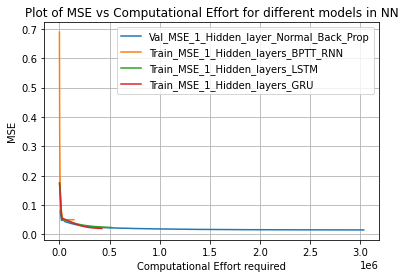

In [56]:
# Computational Effort for individual Algorithms plotted against their Validation MSE to do the comparison between them

from matplotlib import pyplot as plt
plt.plot(epoch_x_mul,history.history['val_mse'], label = 'Val_MSE_1_Hidden_layer_Normal_Back_Prop')
plt.plot(epoch_x_mul_RNN,history_RNN.history['val_mse'], label = 'Train_MSE_1_Hidden_layers_BPTT_RNN')
plt.plot(epoch_x_mul_LSTM,history_LSTM.history['val_mse'], label = 'Train_MSE_1_Hidden_layers_LSTM')
plt.plot(epoch_x_mul_GRU,history_GRU.history['val_mse'], label = 'Train_MSE_1_Hidden_layers_GRU')
plt.grid()
plt.ylabel('MSE')
plt.xlabel('Computational Effort required')
plt.title('Plot of MSE vs Computational Effort for different models in NN')
plt.legend()

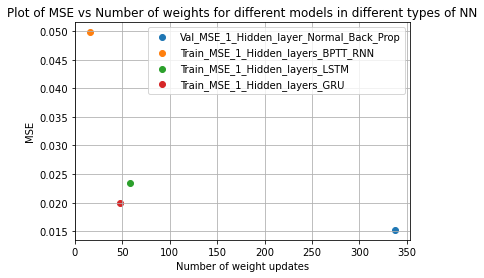

In [58]:
# MSE value at the last epoch for each model vs number of weights for the model to reach that MSE value

from matplotlib import pyplot as plt
plt.scatter(model.count_params(),history.history['val_mse'][-1], label = 'Val_MSE_1_Hidden_layer_Normal_Back_Prop')
plt.scatter(model_RNN.count_params(),history_RNN.history['val_mse'][-1], label = 'Train_MSE_1_Hidden_layers_BPTT_RNN')
plt.scatter(model_LSTM.count_params(),history_LSTM.history['val_mse'][-1], label = 'Train_MSE_1_Hidden_layers_LSTM')
plt.scatter(model_GRU.count_params(),history_GRU.history['val_mse'][-1], label = 'Train_MSE_1_Hidden_layers_GRU')
plt.grid()
plt.ylabel('MSE')
plt.xlabel('Number of weight updates')
plt.title('Plot of MSE vs Number of weights for different models in different types of NN')
plt.legend()

# Comparison

**1. From the graphs, it is evident that best performing model is GRU based on different factors taken into account together including MSE and computational power required.** <br>
**2. We can say that Simple Back Propogation is doing better than the Recurrent Models which are RNN, LSTM and GRU using Loss Function which we are interested in to see how well the algorithms have performed. This Loss Function of MSE says that Simple Back Propogation is doing good than these Recurrent Networks with the difference of hardly half percent better MSE as compared to GRU and 1% better as compared to LSTM.** <br>
**3. But this some what better MSE is achieved by having large number of connection weights in the network. All these weights are updated every time we run the model. This model is computationally very expensive to get even a few % better MSE. Wasting soo much of the computation power to get few % better accuracy on Validation data doesn't make sense. Also, it takes more time to come to that result which is also an issue.** <br>
**4. For the GRU model, MSE of around 0.02 is achieved using only 50 weight connections whereas to get 0.015 MSE using Simple Back Propogation we have to use 350 weights. The number of weights in the model is almost equal to the number of training samples making it 1 sample for each weight roughly. So, to achieve only 0.5% better Forecast results we have to update 7 times more weights at each iteration which does not make sense. Also, computationally talking for Simple Back Propogation we require 1 order higher computation power to achive only 0.5 to 1% better results for the MSE. If the computation power required by GRU is 100,000 then Back Propogation requires 10,000,000 1 order higher computation power to achieve results.** <br>
**5. For the Recurrent type of networks, RNN has the least number of free parameters due to the fact that weights are the same for the incoming, outgoing and recuurent networks. These weights are same when unrolling the network so the computational effort required is less as compared to LSTM and GRU where we have more free parameters to update but fewer gates to reduce this computational effort from 5 in RNN to 4 in LSTM and 3 in GRU** <br>
**6. Also, from the graphs for Train and Validation MSE plots we can see that the models are not overfitting as the MSE for both Train and Validation are almost the same with slight variation for LSTM and GRU Network but still is ok for the performance not overfitting.** <br>
**7. This performance can also be due to the dataset in hand. For some other dataset, this may change and we may see a substancial difference in the performance of the Recurrent Models like LSTM and GRU over Simple Back Propogation or BPTT. Also, the problem here we have is a univariate time series modeling which only takes into account date time and not other features which would influence the models.** <br>